In [2]:
import json
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, matthews_corrcoef, roc_auc_score, 
                             confusion_matrix, classification_report, roc_curve, auc)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

#TODO todays date?
# Account age reference point
REFERENCE_DATE = pd.Timestamp('2022-12-31').tz_localize('UTC')
# Paths
USER_FILE = '../data/twibot22/user.json'
LABEL_FILE = '../data/twibot22/label.csv'
SPLIT_FILE = '../data/twibot22/split.csv'

def load_data():
    print("Loading labels...")
    df_labels = pd.read_csv(LABEL_FILE)
    label_map = dict(zip(df_labels['id'].astype(str), 
                        (df_labels['label'] == 'bot').astype(int)))
    print(f"Loaded {len(label_map)} labels")
    
    print("Loading splits...")
    df_split = pd.read_csv(SPLIT_FILE)
    split_map = dict(zip(df_split['id'].astype(str), df_split['split']))
    print(f"Loaded {len(split_map)} splits")
    
    print("Loading user data...")
    with open(USER_FILE, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
    
    data = []
    for i, entry in enumerate(raw_data):
        # Control print
        if (i + 1) % 50000 == 0:
            print(f"  Processing {i+1}/{len(raw_data)}...")
        
        user_id = str(entry.get('id', ''))
        if user_id not in label_map or user_id not in split_map:
            continue
        
        metrics = entry.get('public_metrics', {})
        
        age_days = 0
        try:
            dt = pd.to_datetime(entry.get('created_at'))
            if dt.tz is None: 
                dt = dt.tz_localize('UTC')
            age = (REFERENCE_DATE - dt).days
            age_days = max(age, 0)
        except: 
            pass
        
        img_url = entry.get('profile_image_url', '')

        # Raw features
        features = {
            'id': user_id,
            'followers_count': int(metrics.get('followers_count', 0)),
            'following_count': int(metrics.get('following_count', 0)),
            'tweet_count': int(metrics.get('tweet_count', 0)),
            'listed_count': int(metrics.get('listed_count', 0)),
            'username_length': len(entry.get('username', '')),
            'account_age_days': age_days,
            'verified': 1 if entry.get('verified') is True else 0,
            'default_profile_image': 1 if 'default_profile_images' in img_url else 0,
            'label': label_map[user_id],
            'split': split_map[user_id]
        }
        data.append(features)
    
    df = pd.DataFrame(data)
    print(f"Total: {len(df)} records")
    return df

df = load_data()
print(f"\nDataset splits:\n{df['split'].value_counts()}\nClass distribution:\n{df['label'].value_counts()}")

Loading labels...
Loaded 1000000 labels
Loading splits...
Loaded 1000000 splits
Loading user data...
  Processing 50000/1000000...
  Processing 100000/1000000...
  Processing 150000/1000000...
  Processing 200000/1000000...
  Processing 250000/1000000...
  Processing 300000/1000000...
  Processing 350000/1000000...
  Processing 400000/1000000...
  Processing 450000/1000000...
  Processing 500000/1000000...
  Processing 550000/1000000...
  Processing 600000/1000000...
  Processing 650000/1000000...
  Processing 700000/1000000...
  Processing 750000/1000000...
  Processing 800000/1000000...
  Processing 850000/1000000...
  Processing 900000/1000000...
  Processing 950000/1000000...
  Processing 1000000/1000000...
Total: 1000000 records

Dataset splits:
split
train    700000
val      200000
test     100000
Name: count, dtype: int64
Class distribution:
label
0    860057
1    139943
Name: count, dtype: int64


In [4]:

feature_cols = ['followers_count', 'following_count', 'tweet_count', 'listed_count',
                'username_length', 'account_age_days', 'verified', 'default_profile_image']

# Log // todo log age?
for col in ['followers_count', 'following_count', 'tweet_count', 'listed_count']:
    df[f'log_{col}'] = np.log1p(df[col])

log_features = ['log_followers_count', 'log_following_count', 'log_tweet_count', 'log_listed_count']
other_features = ['username_length', 'account_age_days', 'verified', 'default_profile_image']
feature_cols_final = log_features + other_features

print("Log normalization applied")

X_train = df[df['split'] == 'train'][feature_cols_final].copy()
y_train = df[df['split'] == 'train']['label']
X_valid = df[df['split'] == 'val'][feature_cols_final].copy()
y_valid = df[df['split'] == 'val']['label']
X_test = df[df['split'] == 'test'][feature_cols_final].copy()
y_test = df[df['split'] == 'test']['label']

# Z-score
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=feature_cols_final)
X_valid = pd.DataFrame(X_valid, columns=feature_cols_final)
X_test = pd.DataFrame(X_test, columns=feature_cols_final)

print("Z-score normalization applied")

print(f"Train: {len(X_train)}, Valid: {len(X_valid)}, Test: {len(X_test)}")

#todo
print("\nTraining RandomForest...")
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5,
                                  min_samples_leaf=2, class_weight='balanced', 
                                  random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

def evaluate(X, y, name):
    y_pred = rf_model.predict(X)
    y_proba = rf_model.predict_proba(X)[:, 1]
    
    metrics = {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred, zero_division=0),
        'Recall': recall_score(y, y_pred, zero_division=0),
        'F1': f1_score(y, y_pred, zero_division=0),
        'MCC': matthews_corrcoef(y, y_pred),
        #'ROC-AUC': roc_auc_score(y, y_proba)
    }
    
    print(f"\n {name}:")
    for metric, value in metrics.items():
        print(f"  {metric:12s}: {value:.4f}")
    
    return metrics, y_pred, y_proba

train_metrics, y_train_pred, y_train_proba = evaluate(X_train, y_train, "TRAIN")
valid_metrics, y_valid_pred, y_valid_proba = evaluate(X_valid, y_valid, "VALIDATION")
test_metrics, y_test_pred, y_test_proba = evaluate(X_test, y_test, "TEST")

# save model
joblib.dump(rf_model, '../models/twibot22_rf.joblib')
print("\n Model saved")

Log normalization applied
Z-score normalization applied
Train: 700000, Valid: 200000, Test: 100000

Training RandomForest...

 TRAIN:
  Accuracy    : 0.8977
  Precision   : 0.4229
  Recall      : 0.8563
  F1          : 0.5662
  MCC         : 0.5570

 VALIDATION:
  Accuracy    : 0.6664
  Precision   : 0.4219
  Recall      : 0.5222
  F1          : 0.4667
  MCC         : 0.2307

 TEST:
  Accuracy    : 0.6768
  Precision   : 0.4628
  Recall      : 0.6084
  F1          : 0.5257
  MCC         : 0.2936

 Model saved


Plots saved to ../results/01_rf_model_evaluation.png


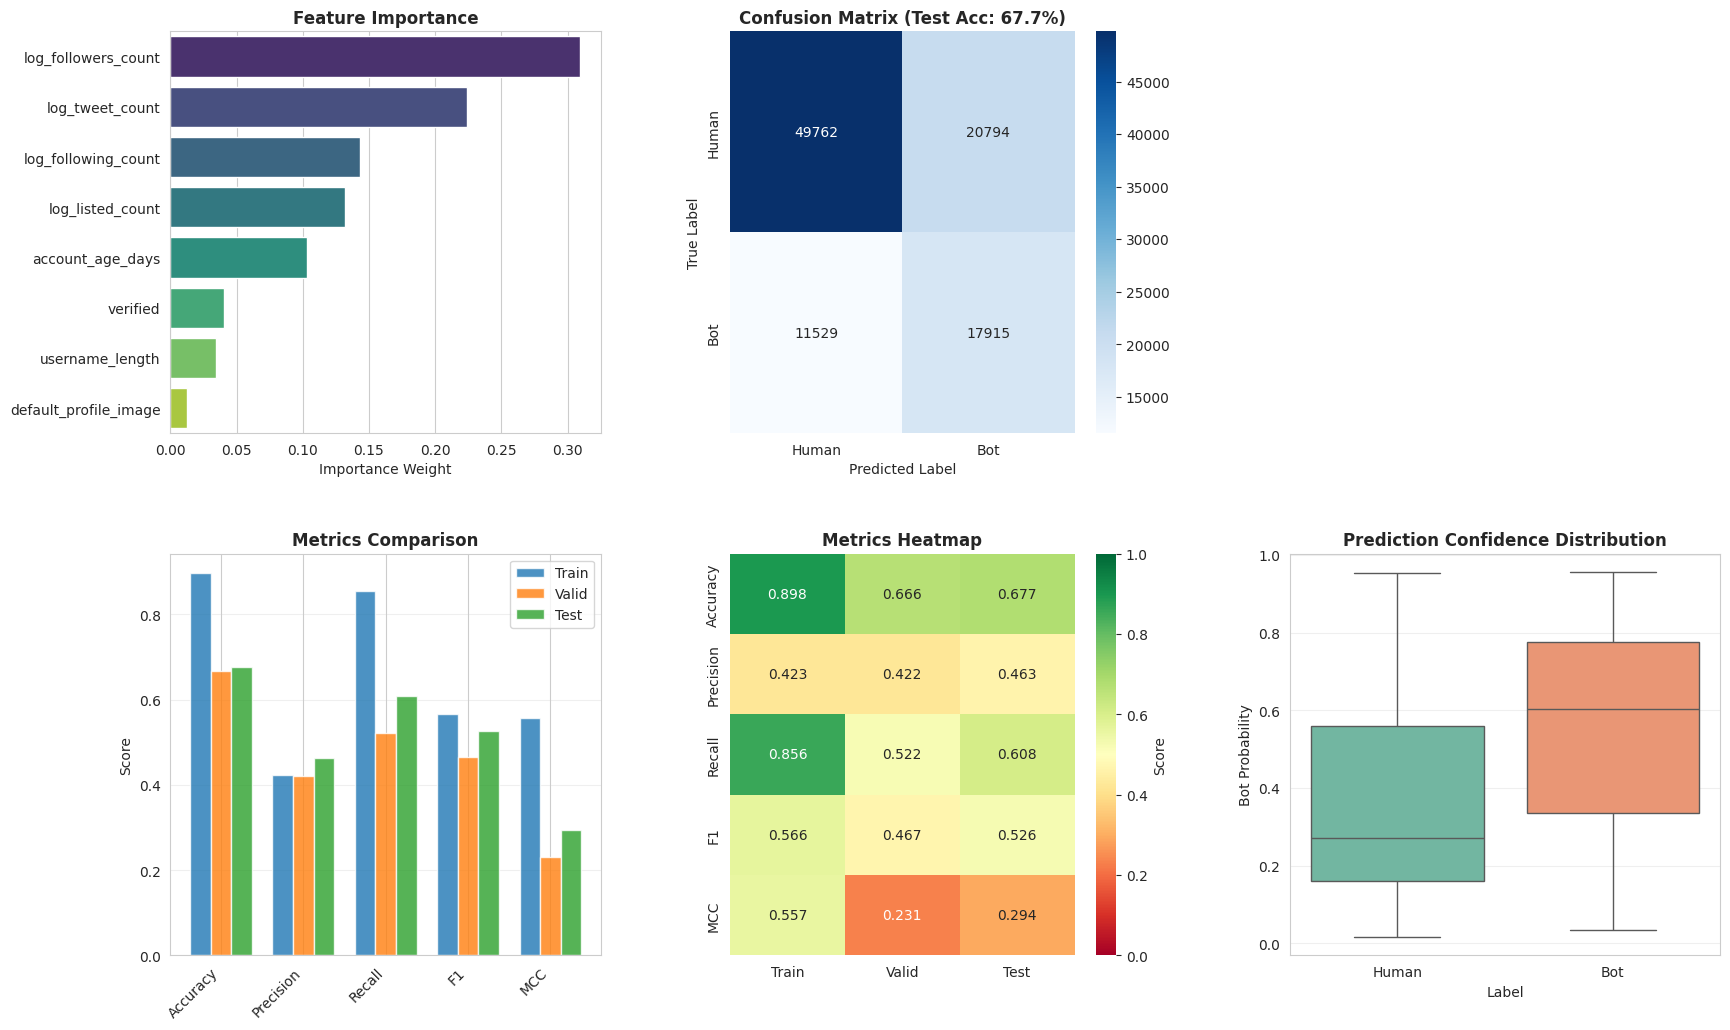

In [5]:


sns.set_style("whitegrid")
fig = plt.figure(figsize=(20, 12))
# 2 x 3 grid
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Feature importance
ax1 = fig.add_subplot(gs[0, 0])
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [feature_cols_final[i] for i in indices]
sns.barplot(x=importances[indices], y=names, ax=ax1, palette="viridis")
ax1.set_title("Feature Importance", fontsize=12, fontweight='bold')
ax1.set_xlabel("Importance Weight")

# Confussion matrix
ax2 = fig.add_subplot(gs[0, 1])
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'])
ax2.set_title(f"Confusion Matrix (Test Acc: {test_metrics['Accuracy']:.1%})", 
              fontsize=12, fontweight='bold')
ax2.set_ylabel("True Label")
ax2.set_xlabel("Predicted Label")

# Metrics comp
ax3 = fig.add_subplot(gs[1, 0])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'MCC']
train_vals = [train_metrics[m] for m in metrics_names]
valid_vals = [valid_metrics[m] for m in metrics_names]
test_vals = [test_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.25
ax3.bar(x - width, train_vals, width, label='Train', alpha=0.8)
ax3.bar(x, valid_vals, width, label='Valid', alpha=0.8)
ax3.bar(x + width, test_vals, width, label='Test', alpha=0.8)
ax3.set_ylabel('Score')
ax3.set_title('Metrics Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics_names, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# metrics heatmap
ax4 = fig.add_subplot(gs[1, 1])
metrics_comparison = pd.DataFrame({
    'Train': train_vals,
    'Valid': valid_vals,
    'Test': test_vals
}, index=metrics_names)
sns.heatmap(metrics_comparison, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax4, 
            cbar_kws={'label': 'Score'}, vmin=0, vmax=1)
ax4.set_title('Metrics Heatmap', fontsize=12, fontweight='bold')

# prediction confidence distribution
ax5 = fig.add_subplot(gs[1, 2])
plot_df = pd.DataFrame({
    'Label': y_test.map({0: 'Human', 1: 'Bot'}),
    'Probability': y_test_proba
})
sns.boxplot(x='Label', y='Probability', data=plot_df, ax=ax5, palette="Set2")
ax5.set_title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
ax5.set_ylabel('Bot Probability')
ax5.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/01_rf_model_evaluation.png', dpi=300, bbox_inches='tight')
print("Plots saved to ../results/01_rf_model_evaluation.png")
plt.show()